In [1]:
cd ..

/home/max/Documents/remb


In [2]:
import numpy as np
import pandas as pd
import torch as T
import torch.nn.functional as F
import torch.nn as nn
from sklearn import metrics
from sklearn.decomposition import PCA
from tqdm import tqdm

from src.simplefact import *
from src.simplefact.syntax import *
from src.reasoner import *
from src.generate import *
from src.utils import *
from src.vis import *

seed = 2022

In [3]:
onto_paths = 'african-wildlife.ofn exchangemodel-noimport.ofn stuff-noimport.ofn swo-noimport.ofn ontodt-noimport.ofn pizza.ofn'.split()
onto_names = 'wildlife demacare stuff swo ontodt pizza'.split()
ontos = []
facts = []
for path in onto_paths:
    onto = load_ofn('local/out/dataset/' + path, silent=True)
    fact = Reasoner.from_onto(onto, timeout=None)
    facts.append(fact)
    ontos.append(onto)
    print(path, '\t', onto)

african-wildlife.ofn 	 <Onto 30 concepts, 5 roles, 49 axioms>
exchangemodel-noimport.ofn 	 <Onto 260 concepts, 53 roles, 369 axioms>
stuff-noimport.ofn 	 <Onto 192 concepts, 46 roles, 314 axioms>
swo-noimport.ofn 	 <Onto 4067 concepts, 39 roles, 7140 axioms>
ontodt-noimport.ofn 	 <Onto 405 concepts, 8 roles, 921 axioms>
pizza.ofn 	 <Onto 99 concepts, 4 roles, 287 axioms>


FaCT++.Kernel: Reasoner for the SROIQ(D) Description Logic, 64-bit
Copyright (C) Dmitry Tsarkov, 2002-2017. Version 1.7.0-SNAPSHOT (01 January 2017)


In [4]:
def make_dataset(onto, fact, n_queries=32_000):
    rng = np.random.default_rng(seed)
    Nc, Nr = onto.n_concepts, onto.n_roles
    gen = AxiomGenerator(rng=rng, n_concepts=Nc, n_roles=Nr, max_depth=4, p_atomic=0.95)

    queries, answers, qset = [], [], set()
    while len(queries) < n_queries:
        axiom = gen()
        axiom_core = core(axiom)
        if axiom_core in qset: continue
        answer = fact.check_axiom(axiom)
        queries.append(axiom_core); answers.append(int(answer)); qset.add(axiom_core)
        
    return queries, answers

idx_te, X_te, y_te = [], [], []
for i, (onto, fact, onto_name) in enumerate(zip(ontos, facts, onto_names)):
    X_te_onto, y_te_onto = make_dataset(onto, fact)
    idx_te += [i]*len(X_te_onto)
    print(onto_name, '- balance', np.round(np.mean(y_te_onto), 4))
    X_te += X_te_onto
    y_te += y_te_onto
    
rng = np.random.default_rng(seed)
data = idx_te, X_te, y_te = jointshuffle(rng, idx_te, X_te, y_te)

wildlife - balance 0.1209
demacare - balance 0.0424
stuff - balance 0.2308
swo - balance 0.2867
ontodt - balance 0.0894
pizza - balance 0.4111


In [5]:
ts = timestr()

emb_size = 10
embs_params = dict(emb_size=emb_size)
head_params = dict(emb_size=emb_size, hidden_size=16)
train_params = dict(epoch_count=10, batch_size=32)

T.manual_seed(seed)
unfrozen_r_embs = EmbeddingLayer.from_ontos(ontos, emb_size=emb_size)
unfrozen_r_head = ReasonerHead(**head_params)

T.manual_seed(seed)
transfer_r_embs = EmbeddingLayer.from_ontos(ontos, emb_size=emb_size)
transfer_r_head = ReasonerHead(**head_params)
transfer_r_head.load_state_dict(T.load('local/out/exp/20220715T194304/reasoner.pt'))

T.manual_seed(seed)
random_r_embs = EmbeddingLayer.from_ontos(ontos, emb_size=emb_size)
random_r_head = ReasonerHead(**head_params)

print('unfrozen reasoner head')
T.manual_seed(seed)
unfrozen_log = train(data, None, unfrozen_r_head, unfrozen_r_embs, run_name='unfrozen', **train_params)

print('----')

print('frozen reasoner head (transfer)')
T.manual_seed(seed)
transfer_log = train(data, None, transfer_r_head, transfer_r_embs, freeze_reasoner=True, run_name='frozen transfer', **train_params)

print('----')

print('frozen reasoner head (random)')
T.manual_seed(seed)
random_log = train(data, None, random_r_head, random_r_embs, freeze_reasoner=True, run_name='frozen random', **train_params)

unfrozen reasoner head
train epoch 00/10 | batch 6001/6000 | loss 0.6852 | val loss 0.6852 | acc 0.6468 | f1 0.3699 | prec 0.2851 | recall 0.5267 | roc auc 0.6519 | pr auc 0.2632 | elapsed 56.48s
train epoch 01/10 | batch 6001/6000 | loss 0.3451 | val loss 0.2028 | acc 0.9284 | f1 0.8049 | prec 0.8678 | recall 0.7505 | roc auc 0.9545 | pr auc 0.8795 | elapsed 171.67s
train epoch 02/10 | batch 6001/6000 | loss 0.1830 | val loss 0.1594 | acc 0.9453 | f1 0.8557 | prec 0.8906 | recall 0.8236 | roc auc 0.9710 | pr auc 0.9187 | elapsed 176.14s
train epoch 03/10 | batch 6001/6000 | loss 0.1551 | val loss 0.1405 | acc 0.9521 | f1 0.8750 | prec 0.9001 | recall 0.8513 | roc auc 0.9775 | pr auc 0.9341 | elapsed 188.00s
train epoch 04/10 | batch 6001/6000 | loss 0.1395 | val loss 0.1276 | acc 0.9571 | f1 0.8889 | prec 0.9055 | recall 0.8729 | roc auc 0.9814 | pr auc 0.9441 | elapsed 180.07s
train epoch 05/10 | batch 6001/6000 | loss 0.1271 | val loss 0.1155 | acc 0.9613 | f1 0.9003 | prec 0.9144 |

local/out/exp/20220719T213232
------
Unfrozen reasoner head
train time 1638.0117859840393
           mean     std   micro
acc      0.9766  0.0135  0.9766
prec     0.9425  0.0489  0.9456
recall   0.9017  0.0772  0.9348
f1       0.9207  0.0574  0.9402
auc_roc  0.9907  0.0076  0.9936
auc_pr   0.9637  0.0343  0.9811
------
Frozen pre-trained reasoner head
train time 1445.934199810028
           mean     std   micro
acc      0.9600  0.0219  0.9600
prec     0.9121  0.0605  0.9127
recall   0.8449  0.1122  0.8813
f1       0.8755  0.0838  0.8967
auc_roc  0.9776  0.0156  0.9832
auc_pr   0.9284  0.0566  0.9497
------
Frozen random reasoner head
train time 1444.492948293686
           mean     std   micro
acc      0.7789  0.0468  0.7789
prec     0.3672  0.2526  0.4475
recall   0.4371  0.1679  0.5233
f1       0.3879  0.2198  0.4825
auc_roc  0.7230  0.0819  0.7594
auc_pr   0.3460  0.2497  0.3934


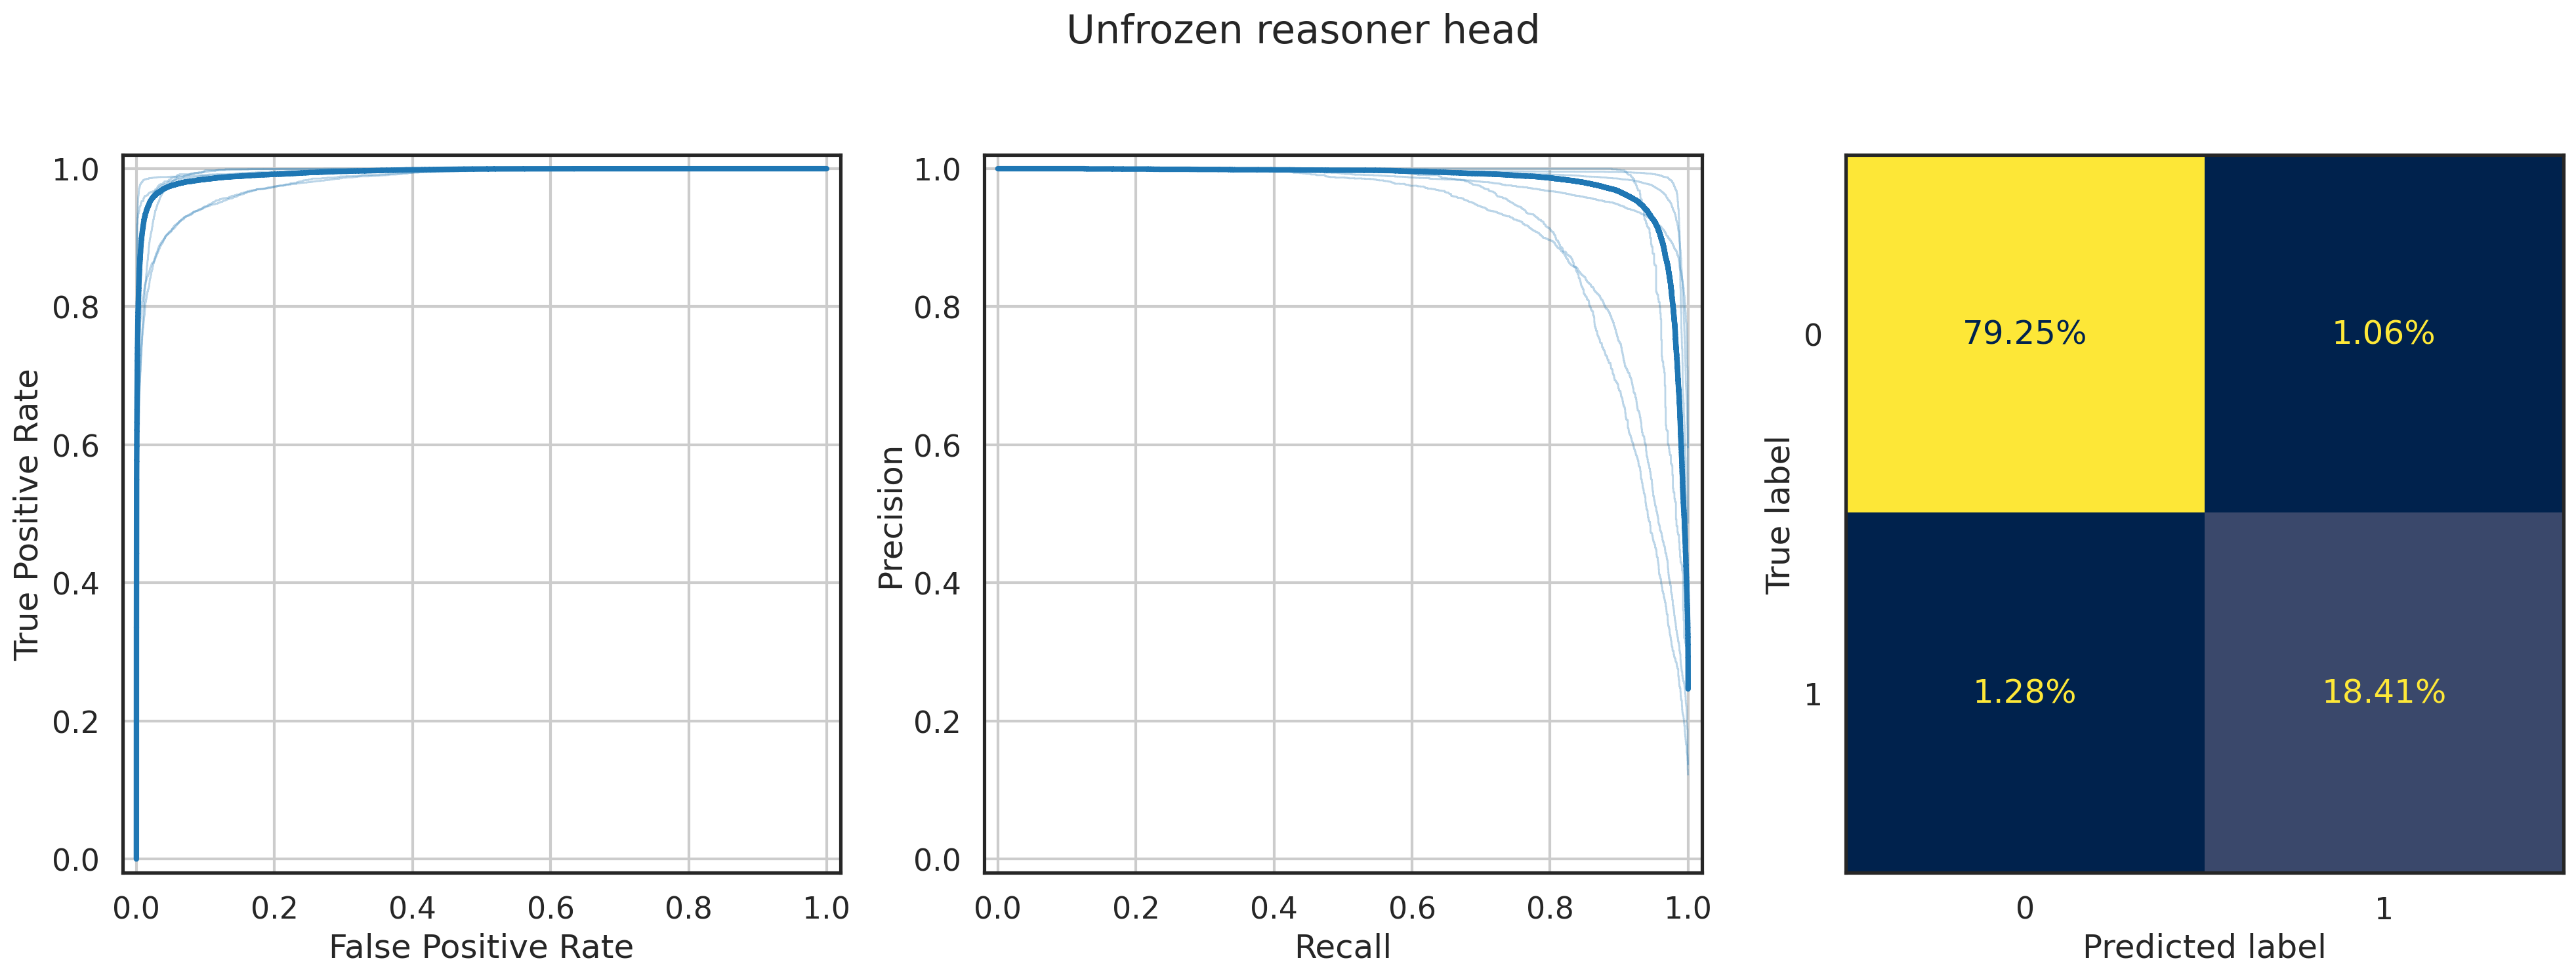

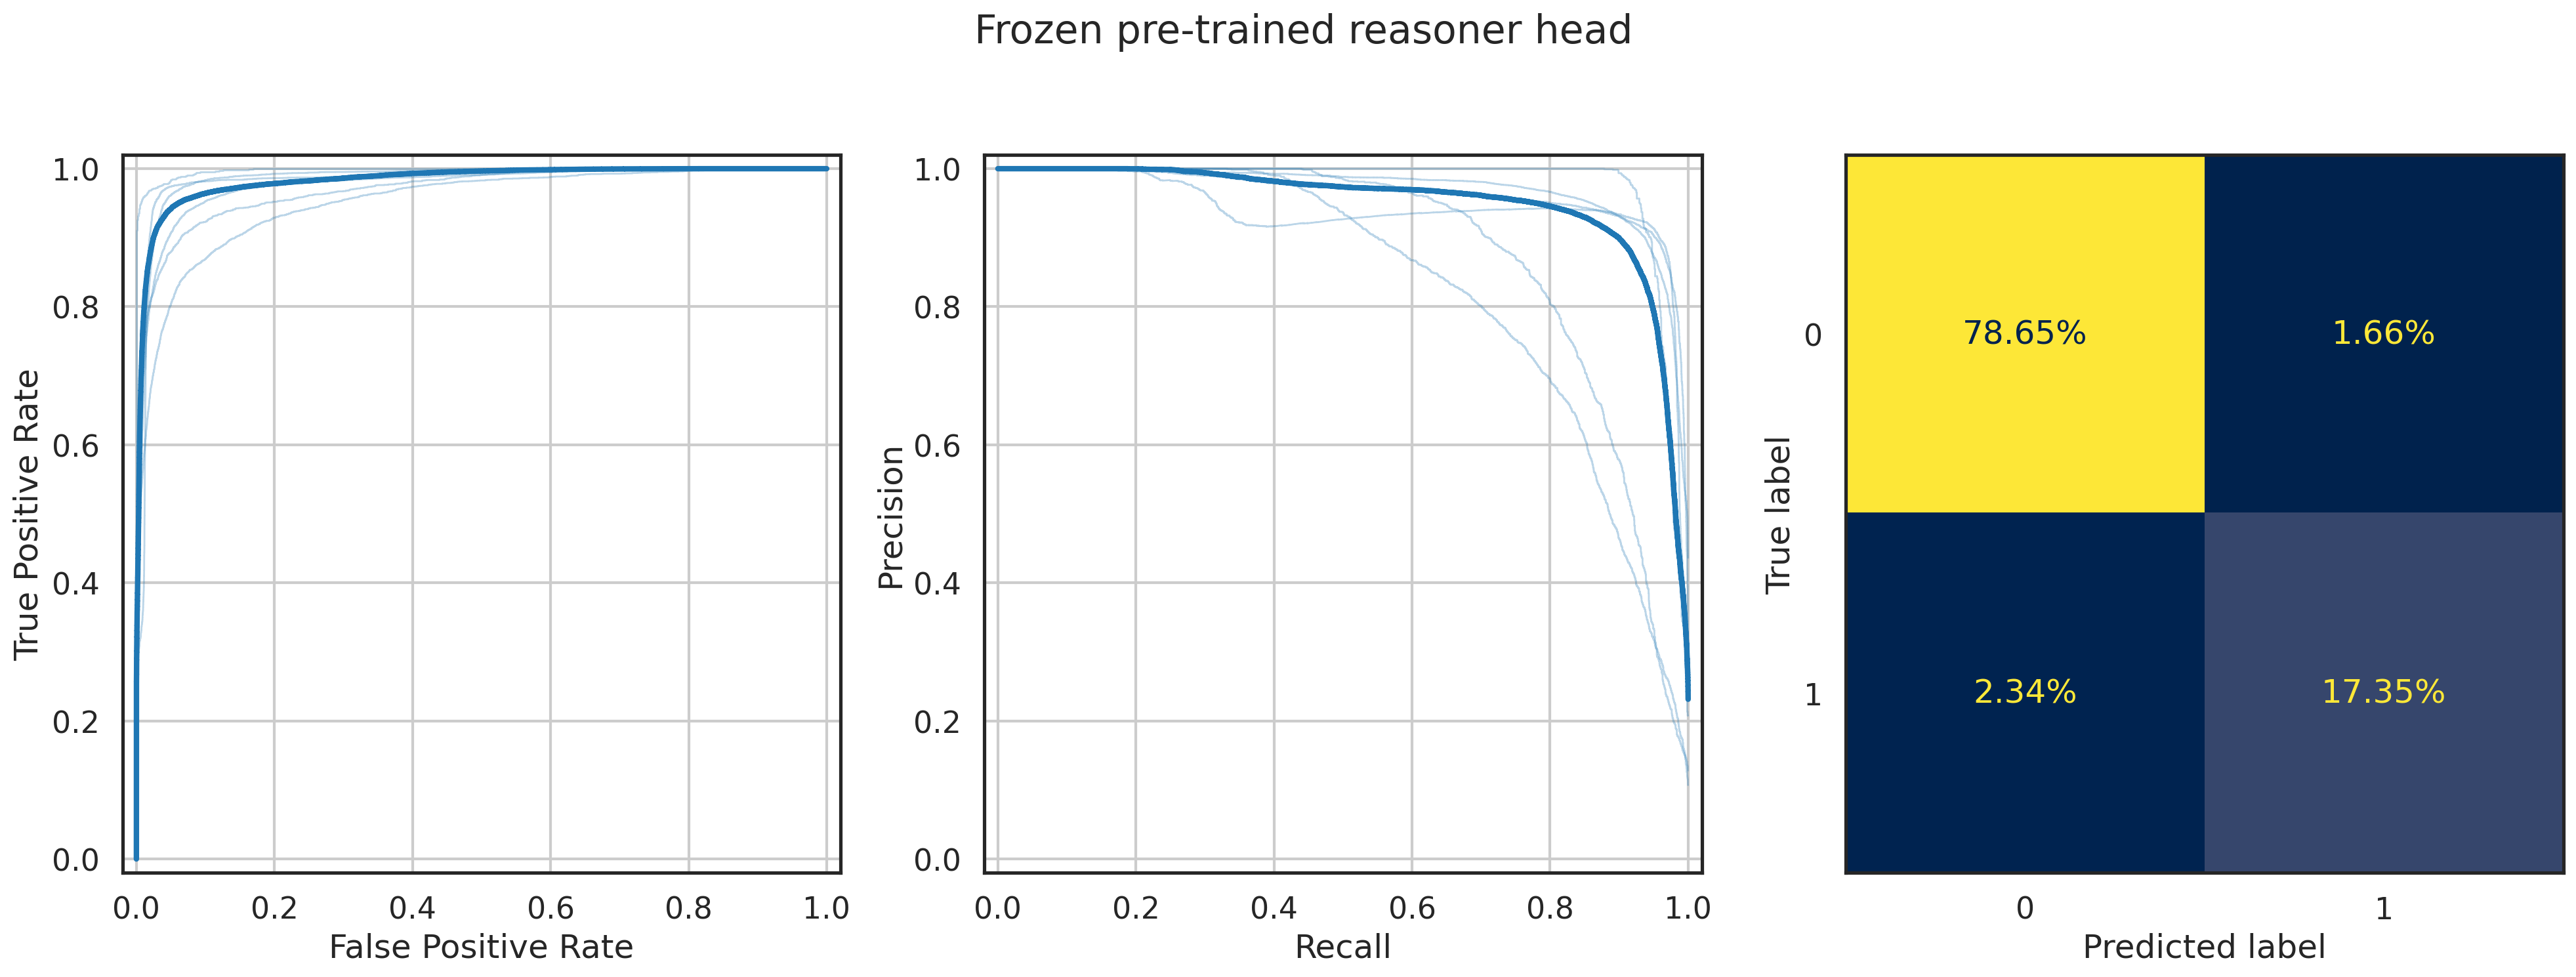

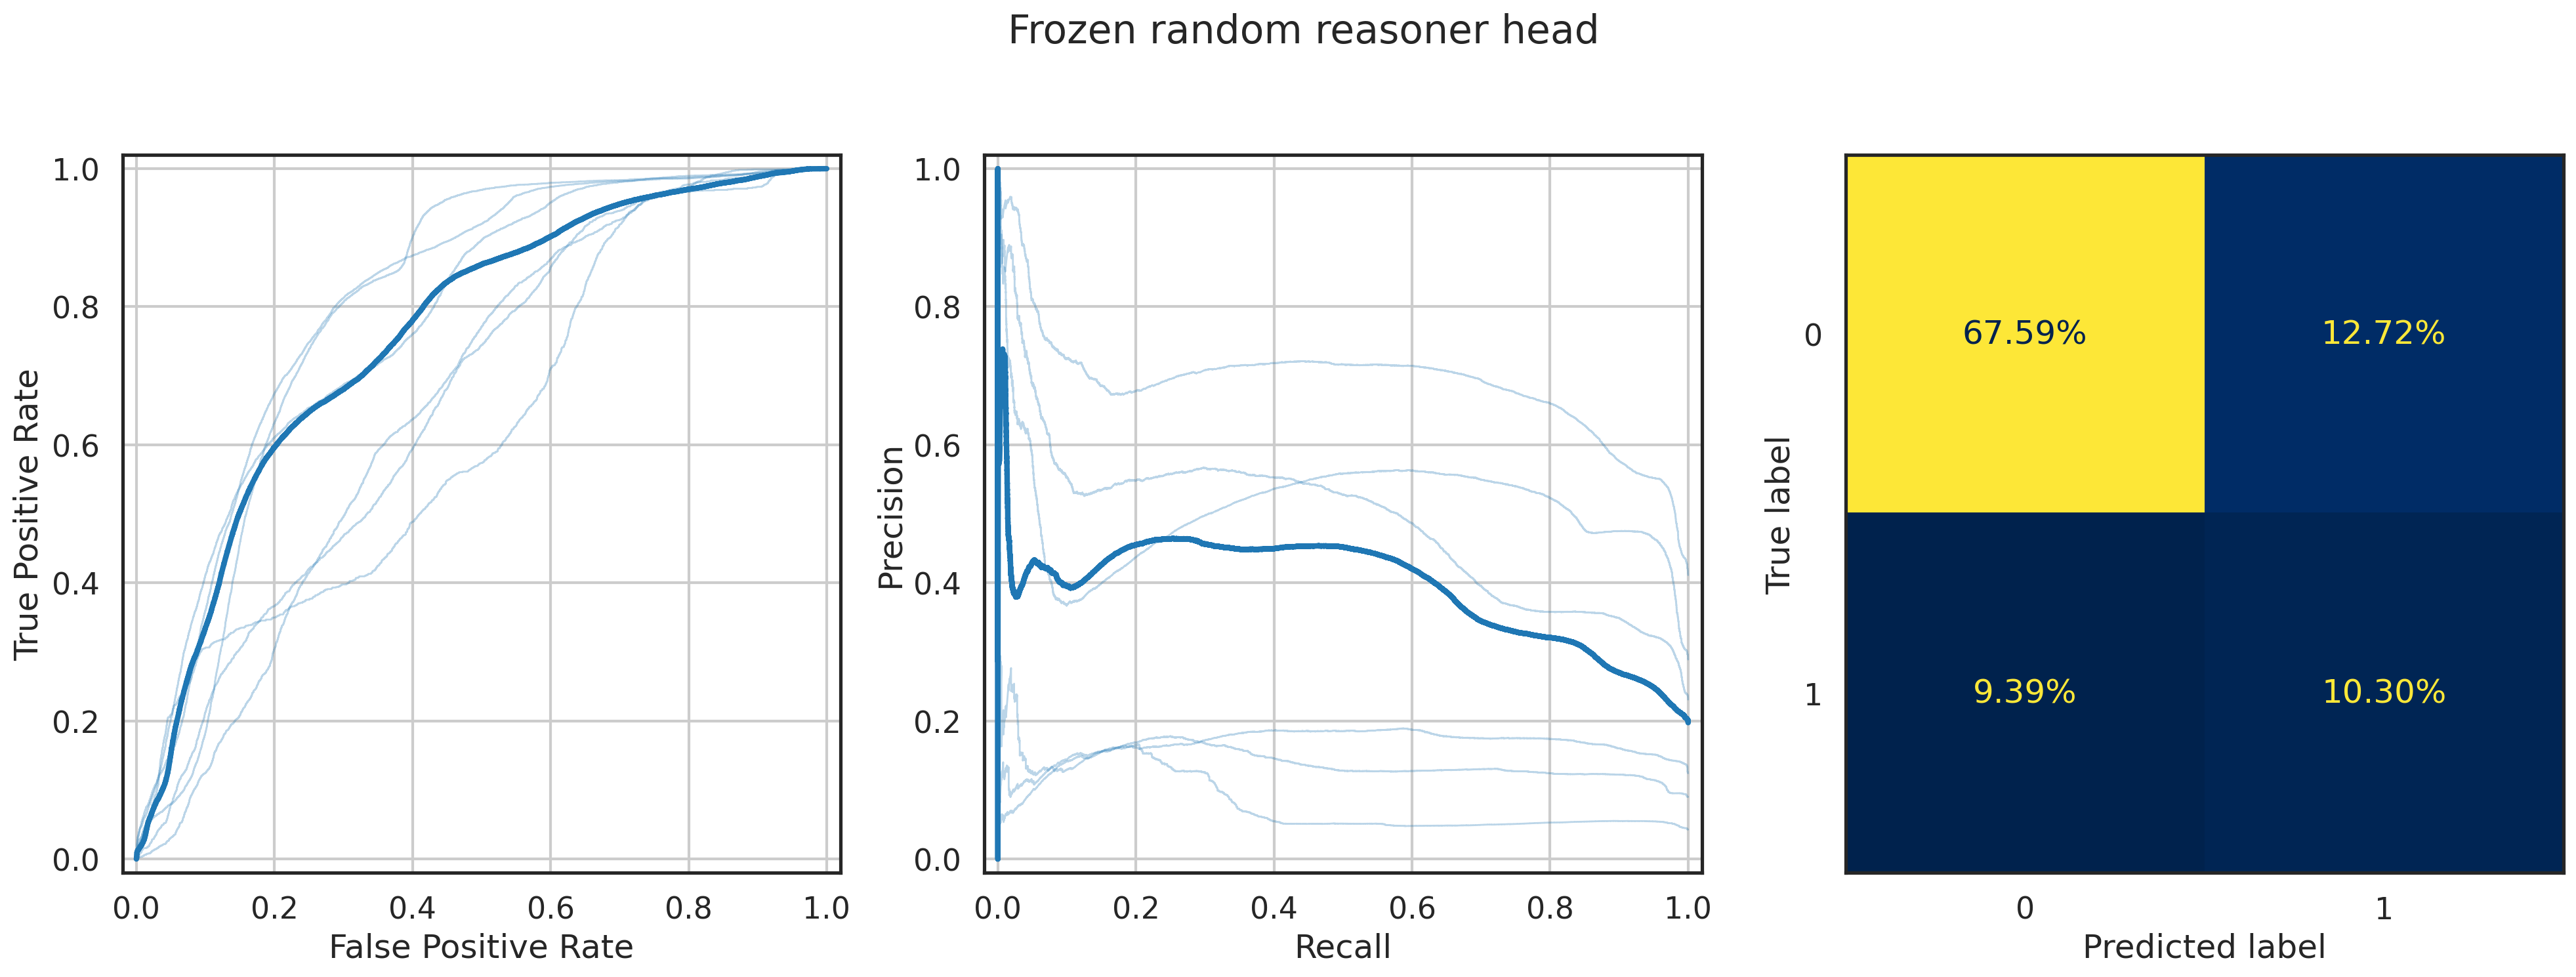

In [6]:
titles = 'Expected', 'Unfrozen reasoner head', 'Frozen pre-trained reasoner head', 'Frozen random reasoner head'
logs = unfrozen_log, transfer_log, random_log
heads = unfrozen_r_head, transfer_r_head, random_r_head
embeddings = unfrozen_r_embs, transfer_r_embs, random_r_embs

base = 'local/out/exp/' + ts
mkdirp(base)
print(base)

for head, embs, log, title in zip(heads, embeddings, logs, titles[1:]):
    print('------')
    with T.no_grad():
        head.eval()
        _, _, Y_te = eval_batch(head, embs, X_te, y_te, idx_te)
    print(title)
    
    history_tr = pd.DataFrame(log.history_tr)
    test_history_by_onto = pd.DataFrame(log.history_vl_by_onto)
    test_history = pd.DataFrame(log.history_vl)
    test_results = pd.DataFrame(dict(idx_te=idx_te, y_te=y_te, Y_te=Y_te))
    test_history.to_csv(base+f'/{title} test.csv', index=False)
    test_history_by_onto.to_csv(base+f'/{title} test by onto.csv', index=False)
    test_results.to_csv(base+f'/{title} test clas.csv', index=False)

    print('train time', history_tr.groupby('epoch').max().elapsed.sum())
    print(report(ontos, y_te, Y_te, idx_te).round(4))
    plt.suptitle(title)

In [7]:
for head, embs, log, title in zip(heads, embeddings, logs, titles[1:]):
    df = pd.DataFrame(log.history_vl_by_onto)
    df = df[df.epoch == df.epoch.max()].drop(columns=['epoch', 'run', 'elapsed'])
    df.onto = df.onto.map(onto_names.__getitem__)
    print('-'*10)
    print(title)
    #print(df.agg(['mean', 'std']).round(4).T)
    print(df.round(4))

----------
Unfrozen reasoner head
       acc      f1    prec  recall  roc_auc  pr_auc      onto
60  0.9639  0.8466  0.8697  0.8247   0.9803  0.9214  wildlife
61  0.9956  0.9449  0.9984  0.8969   0.9979  0.9772  demacare
62  0.9903  0.9789  0.9853  0.9725   0.9970  0.9921     stuff
63  0.9635  0.9377  0.9175  0.9588   0.9929  0.9808       swo
64  0.9752  0.8515  0.9187  0.7934   0.9821  0.9187    ontodt
65  0.9710  0.9647  0.9654  0.9640   0.9940  0.9920     pizza
----------
Frozen pre-trained reasoner head
       acc      f1    prec  recall  roc_auc  pr_auc      onto
60  0.9428  0.7441  0.8105  0.6877   0.9518  0.8363  wildlife
61  0.9956  0.9453  0.9984  0.8976   0.9977  0.9762  demacare
62  0.9658  0.9260  0.9258  0.9261   0.9831  0.9410     stuff
63  0.9558  0.9234  0.9179  0.9290   0.9861  0.9640       swo
64  0.9672  0.7960  0.8981  0.7148   0.9704  0.8828    ontodt
65  0.9328  0.9180  0.9218  0.9143   0.9768  0.9700     pizza
----------
Frozen random reasoner head
       acc     